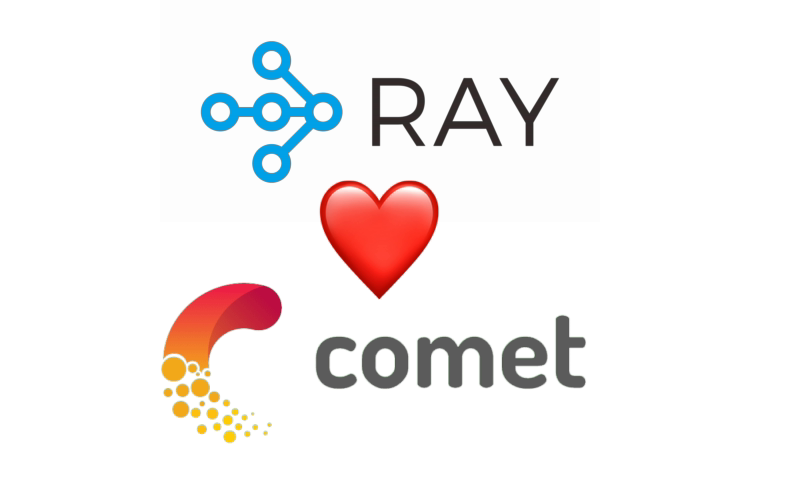

[Ray](https://www.ray.io/) is an open source project that makes it simple to scale any compute-intensive Python workload — from deep learning to production model serving. With a rich set of libraries and integrations built on a flexible distributed execution framework, Ray makes distributed computing easy and accessible to every engineer.


[Comet](https://www.comet.ml/site/data-scientists/?utm_campaign=gradio-integration&utm_medium=colab) is an MLOps Platform that is designed to help Data Scientists and Teams build better models faster! Comet provides tooling to track, Explain, Manage, and Monitor your models in a single place! It works with Jupyter Notebooks and Scripts and most importantly it's 100% free!

To learn more about this integration, please visit
the [Comet Documentation](https://www.comet.ml/docs/v2/integrations/ml-frameworks/ray/)

# Install Depenencies

In [ ]:
%pip install -U "comet_ml>=3.44.0" "ray[tune]"

# Login to Comet

In [ ]:
import comet_ml

comet_ml.login(project_name="comet-example-ray-tune-hello-world")

# Logging a Simple Training Function

In this example, we will define a simple training function that accepts two parameters from our search config, `mean` and `sd`. The training function simply scales and shifts a random number using these parameters and reports the resulting value to Tune.

We will use the `CometLoggerCallback` to log these reported results to Comet, which will allow us to visualize, compare and analyze this experimentation data using a host of tools available on the Comet Platform.

In [ ]:
import numpy as np

import ray
from ray import tune, air, train
from ray.air.integrations.comet import CometLoggerCallback
from ray.air.config import ScalingConfig


def train_function(config):
    for i in range(30):
        loss = config["mean"] + config["sd"] * np.random.randn()
        train.report({"loss": loss})


def tune_function():
    search_space = {
        "mean": tune.grid_search([1]),
        "sd": tune.grid_search([0.2, 0.8]),
        "scaling_config": ScalingConfig(num_workers=1),
    }

    callback = CometLoggerCallback(
        tags=["comet_example"],
    )

    tuner = tune.Tuner(
        train_function,
        param_space=search_space,
        run_config=air.RunConfig(
            name="comet",
            verbose=2,
            callbacks=[callback],
        ),
        tune_config=tune.TuneConfig(
            mode="min",
        ),
    )
    results = tuner.fit()
    ray.shutdown()
    return results

## Run Ray Tune

In [ ]:
results = tune_function()
print(results.get_best_result(metric="loss", mode="min").config)

# Logging an RLLib Run

The `CometLoggerCallback` can also be used with other Ray modules, such as `rllib`. Simply pass the callback object to the `tune.run()` method to log the parameters and metrics produced when tuning a model wtih `rllib`   

## Install RLLib

In [ ]:
%pip install "ray[rllib]" torch

## Define Training Function

In [ ]:
import os
import ray
from ray import tune, air
from ray.air.integrations.comet import CometLoggerCallback
from ray.rllib.utils.test_utils import check_learning_achieved

config = {
    "env": "CartPole-v0",
    # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.
    "num_gpus": int(os.environ.get("RLLIB_NUM_GPUS", "0")),
    "framework": "torch",
    # Run with tracing enabled for tfe/tf2.
    "eager_tracing": False,
    "num_workers": 0,  # Only local worker
}


stop = {"training_iteration": 10}

tuner = tune.Tuner(
    "PPO",
    param_space=config,
    run_config=air.RunConfig(
        stop=stop,
        verbose=2,
        callbacks=[
            CometLoggerCallback(
                tags=["comet_example"],
            )
        ],
    ),
)

results = tuner.fit()

check_learning_achieved(results, 100)